In [65]:
from __future__ import absolute_import, division, print_function

%matplotlib inline
# %matplotlib nbagg
import tensorflow as tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from data_generator_tensorflow import get_batch, print_valid_characters

import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils 

import tf_utils

# Recurrent Neural Networks

In this exercise I'll use the Encoder-Decoder model

### The Data
Since RNN models can be very slow to train on real large datasets we will generate some simpler training data for this exercise. The task for the RNN is simply to translate a string of letters spelling the numbers between 0-9 into the corresponding numbers i.e

    "one two five" --> "125#"

`#` is a special end-of-sequence character, indicating the sequence is done.

To input the strings into the RNN model we translate the characters into a vector integers using a simple translation table (i.e. 'h'->16, 'o'-> 17 etc).
The code below prints a few input/output pairs using the *get_batch* function which randomy produces the data.


In the data loader below will setup the data and print some information. 
Key to understand are:
 * ENCODED INPUTS (`inputs`) are feed into the encoder (`A B C D` in the figure)
 * ENCODED TARGETS OUTPUT (`targets_out`) are what we want the network to predict. This is used to compute the error. (`X Y Z EOS` in the figure) 
 * ENCODED TARGETS INPUT (`targets_in`) are used for teacher forcing during training. (`EOS X Y Z` in the figure) 
 
Note; that we use the same symbol for end-of-sequence as for start-of-sequence (`#`).


In [66]:
# At the bottom of the script there is some code which saves the model.
# If you wish to restore your model from a previous state use this function.
load_model = False
#load_model = True

In [67]:
batch_size = 3
inputs, inputs_seqlen, targets_in, targets_out, targets_seqlen, targets_mask, \
text_inputs, text_targets_in, text_targets_out = \
    get_batch(batch_size=batch_size, max_digits=4, min_digits=2)

print("input types:", inputs.dtype, inputs_seqlen.dtype, targets_in.dtype, targets_out.dtype, targets_seqlen.dtype)
print_valid_characters()
print("Stop/start character = #")

for i in range(batch_size):
    print("\nSAMPLE",i)
    print("TEXT INPUTS:\t\t\t", text_inputs[i])
    print("ENCODED INPUTS:\t\t\t", inputs[i])
    print("INPUTS SEQUENCE LENGTH:\t\t", inputs_seqlen[i])
    print("TEXT TARGETS OUTPUT:\t\t", text_targets_out[i])
    print("TEXT TARGETS INPUT:\t\t", text_targets_in[i])
    print("ENCODED TARGETS OUTPUT:\t\t", targets_out[i])
    print("ENCODED TARGETS INPUT:\t\t", targets_in[i])
    print("TARGETS SEQUENCE LENGTH:\t", targets_seqlen[i])
    print("TARGETS MASK:\t\t\t", targets_mask[i])

input types: int32 int32 int32 int32 int32
Number of valid characters: 27
'0'=0,	'1'=1,	'2'=2,	'3'=3,	'4'=4,	'5'=5,	'6'=6,	'7'=7,	'8'=8,	'9'=9,	'#'=10,	'e'=11,	'o'=12,	'x'=13,	'g'=14,	'w'=15,	'v'=16,	'f'=17,	's'=18,	' '=19,	'u'=20,	'n'=21,	'i'=22,	't'=23,	'z'=24,	'r'=25,	'h'=26,	
Stop/start character = #

SAMPLE 0
TEXT INPUTS:			 two six zero six
ENCODED INPUTS:			 [23 15 12 19 18 22 13 19 24 11 25 12 19 18 22 13]
INPUTS SEQUENCE LENGTH:		 16
TEXT TARGETS OUTPUT:		 2606#
TEXT TARGETS INPUT:		 #2606
ENCODED TARGETS OUTPUT:		 [ 2  6  0  6 10]
ENCODED TARGETS INPUT:		 [10  2  6  0  6]
TARGETS SEQUENCE LENGTH:	 5
TARGETS MASK:			 [ 1.  1.  1.  1.  1.]

SAMPLE 1
TEXT INPUTS:			 six two seven
ENCODED INPUTS:			 [18 22 13 19 23 15 12 19 18 11 16 11 21  0  0  0]
INPUTS SEQUENCE LENGTH:		 13
TEXT TARGETS OUTPUT:		 627#
TEXT TARGETS INPUT:		 #627
ENCODED TARGETS OUTPUT:		 [ 6  2  7 10  0]
ENCODED TARGETS INPUT:		 [10  6  2  7  0]
TARGETS SEQUENCE LENGTH:	 4
TARGETS MASK:			 [ 1.  1.  1.  1.  0.]

### Encoder-Decoder model setup
Below is the TensorFlow model definition. We use an embedding layer to go from integer representation to vector representation of the input.

TensorFlow has implementations of LSTM and GRU units.
Both implementations assume that the input from the tensor below has the shape **`[batch_size, max_time, input_size]`**.

Note that we have made use of a custom decoder wrapper.

In [68]:
# resetting the graph
tf.reset_default_graph()

# Setting up hyperparameters and general configs
MAX_DIGITS = 10
MIN_DIGITS = 5
NUM_INPUTS = 27
NUM_OUTPUTS = 11 #(0-9 + '#')

BATCH_SIZE = 16
# try various learning rates 1e-2 to 1e-5
LEARNING_RATE = 0.005
X_EMBEDDINGS = 8
t_EMBEDDINGS = 8
NUM_UNITS_ENC = 16
NUM_UNITS_DEC = 16


# Setting up placeholders, these are the tensors that we "feed" to our network
Xs = tf.placeholder(tf.int32, shape=[None, None], name='X_input')
ts_in = tf.placeholder(tf.int32, shape=[None, None], name='t_input_in')
ts_out = tf.placeholder(tf.int32, shape=[None, None], name='t_input_out')
X_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_mask = tf.placeholder(tf.float32, shape=[None, None], name='t_mask')


### Building the model
# first we build the embeddings to make our characters into dense, trainable vectors
X_embeddings = tf.get_variable('X_embeddings', [NUM_INPUTS, X_EMBEDDINGS],
                               initializer=tf.random_normal_initializer(stddev=0.1))
t_embeddings = tf.get_variable('t_embeddings', [NUM_OUTPUTS, t_EMBEDDINGS],
                               initializer=tf.random_normal_initializer(stddev=0.1))

X_embedded = tf.gather(X_embeddings, Xs, name='embed_X')
t_embedded = tf.gather(t_embeddings, ts_in, name='embed_t')


## forward encoding
enc_cell = tf.nn.rnn_cell.GRUCell(NUM_UNITS_ENC)
_, enc_state = tf.nn.dynamic_rnn(cell=enc_cell, inputs=X_embedded,
                                 sequence_length=X_len, dtype=tf.float32)
# use below incase TF's makes issues
# enc_state, _ = tf_utils.encoder(X_embedded, X_len, 'encoder', NUM_UNITS_ENC)
#
# enc_state = tf.concat(1, [enc_state, enc_state])

## decoding
# note that we are using a wrapper for decoding here, this wrapper is hardcoded to only use GRU
# check out tf_utils to see how you make your own decoder

# setting up weights for computing the final output
W_out = tf.get_variable('W_out', [NUM_UNITS_DEC, NUM_OUTPUTS])
b_out = tf.get_variable('b_out', [NUM_OUTPUTS])

dec_out, valid_dec_out = tf_utils.decoder(enc_state, t_embedded, t_len, 
                                          NUM_UNITS_DEC, t_embeddings,
                                          W_out, b_out)

## reshaping to have [batch_size*seqlen, num_units]
out_tensor = tf.reshape(dec_out, [-1, NUM_UNITS_DEC])
valid_out_tensor = tf.reshape(valid_dec_out, [-1, NUM_UNITS_DEC])
# computing output
out_tensor = tf.matmul(out_tensor, W_out) + b_out
valid_out_tensor = tf.matmul(valid_out_tensor, W_out) + b_out

## reshaping back to sequence
b_size = tf.shape(X_len)[0] # use a variable we know has batch_size in [0]
seq_len = tf.shape(t_embedded)[1] # variable we know has sequence length in [1]
num_out = tf.constant(NUM_OUTPUTS) # casting NUM_OUTPUTS to a tensor variable
out_shape = tf.concat([tf.expand_dims(b_size, 0),
                      tf.expand_dims(seq_len, 0),
                      tf.expand_dims(num_out, 0)],
                     axis=0)

out_tensor = tf.reshape(out_tensor, out_shape)
valid_out_tensor = tf.reshape(valid_out_tensor, out_shape)
# handling shape loss
#out_tensor.set_shape([None, None, NUM_OUTPUTS])
y = out_tensor
y_valid = valid_out_tensor

In [69]:
# print all the variable names and shapes
for var in tf.global_variables ():
    s = var.name + " "*(40-len(var.name))
    print(s, var.value().get_shape())

X_embeddings:0                           (27, 8)
t_embeddings:0                           (11, 8)
rnn/gru_cell/gates/kernel:0              (24, 32)
rnn/gru_cell/gates/bias:0                (32,)
rnn/gru_cell/candidate/kernel:0          (24, 16)
rnn/gru_cell/candidate/bias:0            (16,)
W_out:0                                  (16, 11)
b_out:0                                  (11,)
decoder/W_z_x:0                          (8, 16)
decoder/W_z_h:0                          (16, 16)
decoder/b_z:0                            (16,)
decoder/W_r_x:0                          (8, 16)
decoder/W_r_h:0                          (16, 16)
decoder/b_r:0                            (16,)
decoder/W_c_x:0                          (8, 16)
decoder/W_c_h:0                          (16, 16)
decoder/b_h:0                            (16,)


### Defining the cost function, gradient clipping and accuracy
Because the targets are categorical we use the cross entropy error.
As the data is sequential we use the sequence to sequence cross entropy supplied in `tf_utils.py`.
We use the Adam optimizer but you can experiment with the different optimizers implemented in [TensorFlow](https://www.tensorflow.org/api_docs/python/tf/train/Optimizer).

In [70]:
def loss_and_acc(preds):
    # sequence_loss_tensor is a modification of TensorFlow's own sequence_to_sequence_loss
    # TensorFlow's seq2seq loss works with a 2D list instead of a 3D tensors
    loss = tf_utils.sequence_loss_tensor(preds, ts_out, t_mask, NUM_OUTPUTS) # notice that we use ts_out here!

    ## regularization
    #reg_scale = 0.00001
    #regularize = tf.contrib.layers.l2_regularizer(reg_scale)
    #params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    #reg_term = sum([regularize(param) for param in params])
    #loss += reg_term
    
    ## calculate accuracy
    argmax = tf.to_int32(tf.argmax(preds, 2))
    correct = tf.to_float(tf.equal(argmax, ts_out)) * t_mask
    accuracy = tf.reduce_sum(correct) / tf.reduce_sum(t_mask)
    return loss, accuracy, argmax

loss, accuracy, predictions = loss_and_acc(y)
loss_valid, accuracy_valid, predictions_valid = loss_and_acc(y_valid)

# use global step to keep track of our iterations
global_step = tf.Variable(0, name='global_step', trainable=False)

# pick optimizer, try momentum or adadelta
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)

# extract gradients for each variable
grads_and_vars = optimizer.compute_gradients(loss)

## add below for clipping by norm
# gradients, variables = zip(*grads_and_vars)  # unzip list of tuples
# clipped_gradients, global_norm = (
#    tf.clip_by_global_norm(gradients, self.clip_norm) )
# grads_and_vars = zip(clipped_gradients, variables)
# apply gradients and make trainable function
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

In [71]:
# print all the variable names and shapes
# notice that we now have the optimizer Adam as well!
for var in tf.all_variables():
    s = var.name + " "*(40-len(var.name))
    print(s, var.value().get_shape())

Instructions for updating:
Please use tf.global_variables instead.
X_embeddings:0                           (27, 8)
t_embeddings:0                           (11, 8)
rnn/gru_cell/gates/kernel:0              (24, 32)
rnn/gru_cell/gates/bias:0                (32,)
rnn/gru_cell/candidate/kernel:0          (24, 16)
rnn/gru_cell/candidate/bias:0            (16,)
W_out:0                                  (16, 11)
b_out:0                                  (11,)
decoder/W_z_x:0                          (8, 16)
decoder/W_z_h:0                          (16, 16)
decoder/b_z:0                            (16,)
decoder/W_r_x:0                          (8, 16)
decoder/W_r_h:0                          (16, 16)
decoder/b_r:0                            (16,)
decoder/W_c_x:0                          (8, 16)
decoder/W_c_h:0                          (16, 16)
decoder/b_h:0                            (16,)
global_step:0                            ()
beta1_power:0                            ()
beta2_power:0     

### Testing the forward pass

In [72]:
## Start the session
# restricting memory usage
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.35)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))

# Initialize parameters
if load_model:
    try:
        tf.train.Saver().restore(sess, "/save/model.ckpt")
    except:
        sess.run(tf.global_variables_initializer())
        print('Model not found, new parameters initialized')
else:
    sess.run(tf.global_variables_initializer())

In [73]:
# as always, test the forward pass and initialize the tf.Session!
for i in range(batch_size):
    print("\nSAMPLE",i)
    print("TEXT INPUTS:\t\t\t", text_inputs[i])
    print("TEXT TARGETS INPUT:\t\t", text_targets_in[i])

feed_dict = {Xs: inputs, X_len: inputs_seqlen, ts_in: targets_in,
             ts_out: targets_out, t_len: targets_seqlen}

# test training forwardpass
fetches = [y]
res = sess.run(fetches=fetches, feed_dict=feed_dict)
print("y", res[0].shape)

# test validation forwardpass
fetches = [y_valid]
res = sess.run(fetches=fetches, feed_dict=feed_dict)
print("y_valid", res[0].shape)


SAMPLE 0
TEXT INPUTS:			 two six zero six
TEXT TARGETS INPUT:		 #2606

SAMPLE 1
TEXT INPUTS:			 six two seven
TEXT TARGETS INPUT:		 #627

SAMPLE 2
TEXT INPUTS:			 six six
TEXT TARGETS INPUT:		 #66
y (3, 5, 11)
y_valid (3, 5, 11)


In [74]:
#Generate some validation data
X_val, X_len_val, t_in_val, t_out_val, t_len_val, t_mask_val, \
text_inputs_val, text_targets_in_val, text_targets_out_val = \
    get_batch(batch_size=5000, max_digits=MAX_DIGITS, min_digits=MIN_DIGITS)
print("X_val", X_val.shape)
print("t_out_val", t_out_val.shape)

X_val (5000, 57)
t_out_val (5000, 11)


# Training

Training RNN can take a while, especially if you are running it on your laptop.
We won't train the model to completion, as the trends we are interested in can be seen earlier.
If training takes to long feel free to stop it even earlier by interrupting the kernel.

Done
CPU times: user 8min 10s, sys: 58.7 s, total: 9min 9s
Wall time: 3min 1s


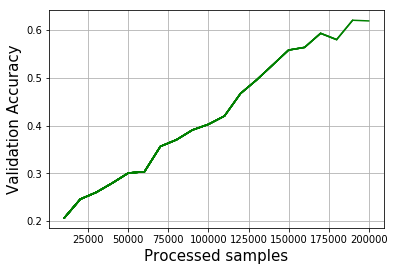

In [75]:
%%time
## If you get an error, remove this line! It makes the error message hard to understand.

# setting up running parameters
val_interval = 5000
samples_to_process = 2e5
samples_processed = 0
samples_val = []
costs, accs_val = [], []
plt.figure()
try:
    while samples_processed < samples_to_process:
        # load data
        X_tr, X_len_tr, t_in_tr, t_out_tr, t_len_tr, t_mask_tr, \
        text_inputs_tr, text_targets_in_tr, text_targets_out_tr = \
            get_batch(batch_size=BATCH_SIZE,max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
        # make fetches
        fetches_tr = [train_op, loss, accuracy]
        # set up feed dict
        feed_dict_tr = {Xs: X_tr, X_len: X_len_tr, ts_in: t_in_tr,
             ts_out: t_out_tr, t_len: t_len_tr, t_mask: t_mask_tr}
        # run the model
        res = tuple(sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr))
        _, batch_cost, batch_acc = res
        costs += [batch_cost]
        samples_processed += BATCH_SIZE
        #if samples_processed % 1000 == 0: print(batch_cost, batch_acc)
        #validation data
        if samples_processed % val_interval == 0:
            #print("validating")
            fetches_val = [accuracy_valid, y_valid]
            feed_dict_val = {Xs: X_val, X_len: X_len_val, ts_in: t_in_val,
             ts_out: t_out_val, t_len: t_len_val, t_mask: t_mask_val}
            res = tuple(sess.run(fetches=fetches_val, feed_dict=feed_dict_val))
            acc_val, output_val = res
            samples_val += [samples_processed]
            accs_val += [acc_val]
            plt.plot(samples_val, accs_val, 'g-')
            plt.ylabel('Validation Accuracy', fontsize=15)
            plt.xlabel('Processed samples', fontsize=15)
            plt.title('', fontsize=20)
            plt.grid('on')
            plt.savefig("out.png")
            display.display(display.Image(filename="out.png"))
            display.clear_output(wait=True)
except KeyboardInterrupt:
    pass

print('Done')

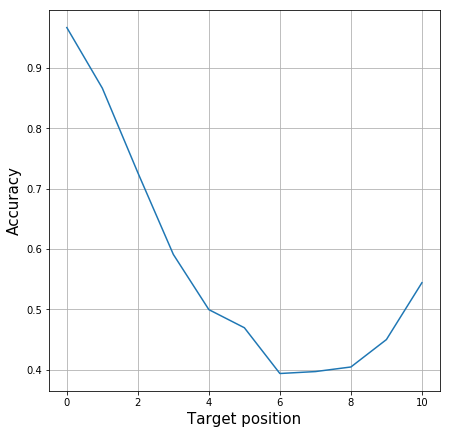

In [77]:
#plot of validation accuracy for each target position
plt.figure(figsize=(7,7))
plt.plot(np.mean(np.argmax(output_val,axis=2)==t_out_val,axis=0))
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Target position', fontsize=15)
#plt.title('', fontsize=20)
plt.grid('on')
plt.show()
# the network is good at the begining but when the sequence is longer it gets harder and harder

In [79]:
## Save model
# Read more about saving and loading models at https://www.tensorflow.org/programmers_guide/saved_model

# Save model
save_path = tf.train.Saver().save(sess, "./save/model.ckpt")
print("Model saved in file: %s" % save_path)


Model saved in file: ./save/model.ckpt


In [103]:
## Close the session, and free the resources
sess.close()